In [253]:
from collections import Counter
from itertools import combinations
from math import sqrt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #comment out this line if you want to use gpu
import random
from keras.layers import Concatenate, Dense, Dot, Dropout, Embedding, Input, Reshape
from keras.models import Model
from keras.callbacks import Callback, ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt

### Set random seed

In [254]:
import random
random.seed(2021)
np.random.seed(2021)
# tf > 2.0
tensorflow.random.set_seed(2021)
#tf < 2.0
#tf.set_random_seed(2021)

### Root Mean Squared Error (RMSE) is used to evaluate the performance of a recommendation algorithm, so we need to define the following utility function to compute the RMSE given the predicted ratings and the ground truth ratings. 

In [255]:
'''
params:
    -pred: an array containing all predicted ratings
    -actual: an array containing all ground truth ratings
    
return:
    a scalar whose value is the rmse
'''
def rmse(pred, actual):
    # Ignore ratings with value zero.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

# Implement Wide and Deep Learning (WDL) Model

### The wide component is a generalized linear model that takes in the raw input features and the cross-product transformation of categorical features, which enables it to learn the frequent co-occurrence of items or features. 

### The deep component is a Feed-forward Neural Network (FNN) which takes in both continuous and categorical features as input. Specifically,  the normalized values of continuous features are concatenated with the low-dimensional dense embedding vectors converted from categorical features. This concatenated vector is then fed into the FNN during each foward pass. This mechanism tend to increase the diversity of recommendations.

In [256]:
'''
params:
    -len_continuous: number of continuous features
    -deep_vocab_lens: an array of integers where deep_vocab_lens[i] represents the number of unique values of (i+1)-th deep 
        categorical feature
    -len_wide: number of wide features
    -embed_size: dimension of the embedding vectors of deep categorical features
    
return:
    a keras Model object for the constructed wdl model 
'''


def build_wdl_model(len_continuous, deep_vocab_lens, len_wide, embed_size):
    # A list containing all input layers
    input_list = []
    
    # Input layer for continuous features
    continuous_input = Input(shape=(len_continuous,), dtype='float32', name='continuous_input')
    input_list.append(continuous_input)
    
    
    # Get embeddings for all deep categorical features
    emb_list = []
    for vocab_size in deep_vocab_lens:
        _input = Input(shape=(1,), dtype='int32')
        input_list.append(_input)
        _emb = Embedding(output_dim=embed_size, input_dim=vocab_size, input_length=1)(_input)
        _emb = Reshape((embed_size,))(_emb)
        emb_list.append(_emb)
    
    
   
    # Create input layer for deep component by concatenating the embeddings and continuous features' input layer
    deep_input = Concatenate()(emb_list + [continuous_input])
    

    # Construct deep component
    dense_1 = Dense(256, activation='relu')(deep_input)
    dense_1_dp = Dropout(0.3)(dense_1)
    dense_2 = Dense(128, activation='relu')(dense_1_dp)
    dense_2_dp = Dropout(0.3)(dense_2)
    dense_3 = Dense(64, activation='relu')(dense_2_dp)
    dense_3_dp = Dropout(0.3)(dense_3)
    dense_4 = Dense(64, activation='relu')(dense_3_dp)
    dense_4_dp = Dropout(0.3)(dense_4)

    
    # Create input layer for wide component
    wide_input = Input(shape=(len_wide,), dtype='float32')
    input_list.append(wide_input)

    
    # Concatenate the outputs of deep and wide components and feed the 
    # concatenated vector into the finall fully connected layer
    fc_input = Concatenate()([dense_4_dp, wide_input])
    model_output = Dense(1)(fc_input)
    
    model = Model(inputs=input_list,
                  outputs=model_output)
    return model
    

# Utility functions to get the values of different types of features

### Continuous features

In [257]:
'''
params:
    -df: input dataframe
    -continuous_columns: column names of continuous features
    
return: 
    a numpy array where each row contains the values of continuous features in the corresponding row of the
    input dataframe
'''
def get_continuous_features(df, continuous_columns):
    continuous_features = df[continuous_columns].values
    return continuous_features

### Cross product transformation of categorical features

In [258]:
'''
params:
    -df: input dataframe
    -comb_p: number of elements in each combination (e.g., there are two elements in the combination {fried chicken, chicken and 
    waffle}, and three elements in the combination {fried chicken, chicken and waffle, chicken fried rice})
    -topk: number of mostly frequent combinations to retrieve
    -output_freq: whether to return the frequencies of retrieved combinations
    
return:
    1. output_freq = True: a list X where each element is a tuple containing a combinantion tuple and corresponding frequency, and the 
        elements are stored in the descending order of their frequencies
    2. output_freq = False: a list X where each element is a tuple containing a combinantion tuple, and the elements are stored in 
    the descending order of their frequencies
'''
def get_top_k_p_combinations(df, comb_p, topk, output_freq=False):
    # get all combinations with comb_p
    def get_category_combinations(categories_str, comb_p=2):
        categories = categories_str.split(', ')
        return list(combinations(categories, comb_p))
    # [('Lounges', 'Dance Clubs'), ('Lounges', 'Bars'), ('Lounges', 'Nightlife'), ('Dance Clubs', 'Bars'), ('Dance Clubs', 'Nightlife'), ('Bars', 'Nightlife')]
    all_categories_p_combos = df["item_categories"].apply(
        lambda x: get_category_combinations(x, comb_p)).values.tolist()
    # ('Lounges', 'Dance Clubs')
    # list of tuples that each index refer to one combination
    all_categories_p_combos = [tuple(t) for item in all_categories_p_combos for t in item]

    tmp = dict(Counter(all_categories_p_combos))
    sorted_categories_combinations = list(sorted(tmp.items(), key=lambda x: x[1], reverse=True))
    if output_freq:
        return sorted_categories_combinations[:topk]
    else:
        return [t[0] for t in sorted_categories_combinations[:topk]]

### Wide features

In [259]:
'''
params:
    -df: input dataframe
    -selected_categories_to_idx: a dictionary mapping item categories to corrresponding integral indices
    -top_combinations: a list containing retrieved mostly frequent combinantions of item categories
    
return:
    a numpy array where each row contains the categorical features' binary encodings and cross product
    transformations for the corresponding row of the input dataframe
'''

def get_wide_features(df, selected_categories_to_idx, top_combinations):
    def categories_to_binary_output(categories):
        binary_output = [0 for _ in range(len(selected_categories_to_idx))]
        for category in categories.split(', '):
            if category in selected_categories_to_idx:
                binary_output[selected_categories_to_idx[category]] = 1
            else:
                binary_output[0] = 1
        return binary_output
    def categories_cross_transformation(categories):
        current_category_set = set(categories.split(', '))
        corss_transform_output = [0 for _ in range(len(top_combinations))]
        for k, comb_k in enumerate(top_combinations):
            if len(current_category_set & comb_k) == len(comb_k):
                corss_transform_output[k] = 1
            else:
                corss_transform_output[k] = 0
        return corss_transform_output

    category_binary_features = np.array(df.item_categories.apply(
        lambda x: categories_to_binary_output(x)).values.tolist())
    print('category_binary_features shape:',category_binary_features.shape)
    category_corss_transform_features = np.array(df.item_categories.apply(
        lambda x: categories_cross_transformation(x)).values.tolist())
    print('category_cross_features shape:',category_corss_transform_features.shape)
    out = np.concatenate((category_binary_features, category_corss_transform_features), axis=1)
    print('wide features shape:',out.shape)
    return np.concatenate((category_binary_features, category_corss_transform_features), axis=1)


# Rating Prediction

### Load train, validation and test rating tables

In [260]:
tr_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/valid.csv")
te_df = pd.read_csv("data/test.csv")

tr_ratings = tr_df.stars.values
val_ratings = val_df.stars.values

{4.0: 21310, 5.0: 20563, 3.0: 10472, 2.0: 4838, 1.0: 2897}


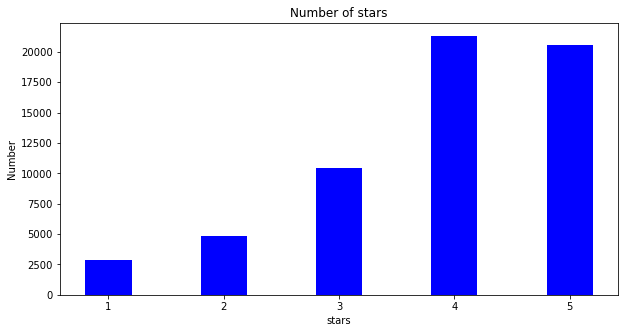

In [308]:
data = dict(tr_df['stars'].value_counts())
print(data)
stars = list(data.keys())
values = list(data.values())

  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(stars, values, color ='blue',
        width = 0.4)
 
plt.xlabel("stars")
plt.ylabel("Number")
plt.title("Number of stars")
plt.savefig('stars.png')
plt.show()

In [379]:
temp_df = tr_df[['business_id', 'stars']].groupby(['business_id']).agg(['mean', 'count']).sort_values(by=[('stars', 'count')], ascending=False)

In [419]:
temp_df

stars      
                                      mean count
business_id                                     
a872871042c5c46838a1ba924dab1f6c  3.578947   114
fd37fd10d66b673df363b646a26c9ab3  4.180952   105
a3e891f8e82805513255e0e0fb1dafa8  4.215190    79
fad6b81d65ddf84ca3830955aa1cb4c7  3.810811    74
f441407637e366ac9dbadc249f6241bb  3.859155    71
...                                    ...   ...
7f3e83d10a8783bb14432f41f4b4523b  4.000000     1
e12df5f4d2e7d26f4e4f5f365ec78011  5.000000     1
2947f860e1259657ce3d83a4cd8669f4  5.000000     1
bce2a9cf1f34e6cd072f02d6eb0a8e67  3.000000     1
3ced7918e9c1429e5c7532cb7b9d99e1  5.000000     1

[5937 rows x 2 columns]

array(['a872871042c5c46838a1ba924dab1f6c',
       'fd37fd10d66b673df363b646a26c9ab3',
       'a3e891f8e82805513255e0e0fb1dafa8',
       'fad6b81d65ddf84ca3830955aa1cb4c7',
       'f441407637e366ac9dbadc249f6241bb',
       '91800fad6f001230fb7605058a360795',
       '918191ea9d67f9f664a111dbce971237',
       '5c998666292d0eb282a3d2b61303e3c4',
       'e07b64d4162dca6e974024978802110f',
       'a89bc7d8407d04163f9f60533cbd4bf0'], dtype=object)

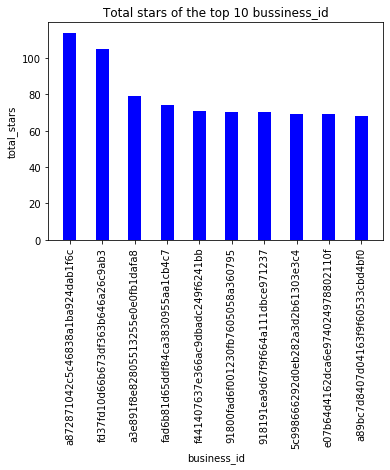

In [415]:
# creating the bar plot
plt.bar(temp_df.iloc[:10,:].index.values, temp_df.iloc[:10,:][('stars', 'count')], color ='blue',
        width = 0.4)
 
plt.xlabel("business_id")
plt.xticks(rotation=90)
plt.ylabel("total_stars")
plt.title("Total stars of the top 10 bussiness_id")
plt.savefig('stars2.png', dpi=10)
plt.show()

['a872871042c5c46838a1ba924dab1f6c' 'fd37fd10d66b673df363b646a26c9ab3'
 'a3e891f8e82805513255e0e0fb1dafa8' 'fad6b81d65ddf84ca3830955aa1cb4c7'
 'f441407637e366ac9dbadc249f6241bb' '91800fad6f001230fb7605058a360795'
 '918191ea9d67f9f664a111dbce971237' '5c998666292d0eb282a3d2b61303e3c4'
 'e07b64d4162dca6e974024978802110f' 'a89bc7d8407d04163f9f60533cbd4bf0']
business_id
a872871042c5c46838a1ba924dab1f6c    114
fd37fd10d66b673df363b646a26c9ab3    105
a3e891f8e82805513255e0e0fb1dafa8     79
fad6b81d65ddf84ca3830955aa1cb4c7     74
f441407637e366ac9dbadc249f6241bb     71
91800fad6f001230fb7605058a360795     70
918191ea9d67f9f664a111dbce971237     70
5c998666292d0eb282a3d2b61303e3c4     69
e07b64d4162dca6e974024978802110f     69
a89bc7d8407d04163f9f60533cbd4bf0     68
Name: (stars, count), dtype: int64


In [334]:
pd.DataFrame(temp_df[('stars', 'mean')], columns=['buiness_id',]

business_id
000d15dc50333655adef063db437888c    3.571429
001bcf6d457dadb09e751b843f9ad028    4.333333
001c90e087a2f1ebb3a90635b34ddd91    3.500000
002d081701fac4a762b9c262f7fce137    4.750000
002dbb0d07f9d9f99d03dda52cebd8a2    4.333333
                                      ...   
ffc5d8ce39cca330c1dc577caa0011b9    3.727273
ffcabb30f80720d52dc01ae35b269dcc    4.285714
ffe237e15fa9bc53bad7224ac5c3f808    5.000000
ffe3f7c65732b15e00551d81744e787d    4.142857
fffc79b331d27270d4f1f927c3163e8d    3.800000
Name: (stars, mean), Length: 5937, dtype: float64

### Load content feautures tables of users and items

In [261]:
user_df = pd.read_csv("data/user.csv")
item_df = pd.read_csv("data/business.csv")

# Rename some columns of dfs and convert the indices of dfs into string type for easier reference in later stage 
user_df = user_df.rename(index=str, columns={t: 'user_' + t for t in user_df.columns if t != 'user_id'})
item_df = item_df.rename(index=str, columns={t: 'item_' + t for t in item_df.columns if t != 'business_id'})


### Associate each row in the rating tables with corresponding user's and item's content features through merging the rating tables and content features tables

In [262]:
# Save the original row indices of each rating table
tr_df["index"] = tr_df.index
val_df["index"]  = val_df.index
te_df["index"] = te_df.index

tr_df = pd.merge(pd.merge(tr_df, user_df, on='user_id'), item_df, on='business_id').sort_values(by=['index']).reset_index(drop=True)
val_df = pd.merge(pd.merge(val_df, user_df, on='user_id'), item_df, on='business_id').sort_values(by=['index']).reset_index(drop=True)
te_df = pd.merge(pd.merge(te_df, user_df, on='user_id'), item_df, on='business_id').sort_values(by=['index']).reset_index(drop=True)

In [263]:
import pandas as pd
import ast
import math

def isnan(value):
  try:
      return math.isnan(float(value))
  except:
      return False
  
def convert_value(value):
  if value == "None":
    return None
  if isinstance(value, bool):
    return 1 if value else 0
  if value.isdecimal():
    return float(value)
  if value == "yes":
    return 1
  if value == "no":
    return 0
  return value

def expand_json_column(df, attributes): 
  for attribute in attributes:
    list_dict = []
    for i,dict_str in enumerate(df[attribute]):

      # check for nan
      if not isnan(dict_str):
        dict_str = dict_str.replace('"','').replace("'False'","False").replace("'True'","True")
        temp_dict = ast.literal_eval(dict_str)

        temptemp_dict = {}
        for k, v in temp_dict.items():
          # print(k, v)
          if isinstance(v, dict):
            for k1, v1 in v.items():
              value = convert_value(v1)
              if value:
                temptemp_dict[f"{k}_{k1}"] = value
          else:
            value = convert_value(v)
            if value:
              temptemp_dict[k] = value
        
        list_dict.append(temptemp_dict)

    new_df = pd.DataFrame(list_dict)
    df = df.join(new_df, lsuffix='_caller', rsuffix='_other')

  return df

def expand_list_column(df, attributes):
  for attribute in attributes:
    list_dict = []
    for i,list_str in enumerate(df[attribute]):

       # check for nan
      if not isnan(list_str):

        temp_dict = {}
        
        for key in list_str.split(','):
          temp_dict[key] = 1
      list_dict.append(temp_dict)

    new_df = pd.DataFrame(list_dict)
    df = df.join(new_df, lsuffix='_caller', rsuffix='_other')
  return df

In [264]:
tr_df = expand_json_column(tr_df,["item_attributes"])
val_df = expand_json_column(val_df,["item_attributes"])
te_df = expand_json_column(te_df,["item_attributes"])

In [265]:
# add columns and reorder the columns in val and test
new_columns = ['HairSpecializesIn_kids', 'HairSpecializesIn_straightperms', 'HairSpecializesIn_perms', 'HairSpecializesIn_asian']
new_data = np.zeros((int(len(val_df)), int(len(new_columns))))
new_val = pd.DataFrame(new_data, columns = new_columns)
val_df = pd.concat((val_df, new_val), axis=1)
val_df = val_df[tr_df.columns]
te_df = te_df[tr_df.columns]

### Construct new train data

In [266]:
### remove the columns with too low frequency
for column in tr_df.iloc[:,97:]:
    tr_df = tr_df.drop([column], axis=1)
    
for column in tr_df.iloc[:,39:97]:
    #print(tr_df[column].unique())
    if len(tr_df[column].unique()) < 3:
        tr_df[column] = tr_df[column].fillna(0)
    else:
        tr_df[column] = tr_df[column].fillna('Nan')
    #print(tr_df[column].value_counts())

for column in tr_df.iloc[:,39:97]:
    if len(tr_df[column].unique()) > 2:
        tr_df = pd.concat([tr_df, pd.get_dummies(tr_df[column], prefix=column)], axis=1)
        tr_df = tr_df.drop([column],axis=1)

### Construct new valid data

In [267]:
### remove the columns with too low frequency
for column in val_df.iloc[:,97:]:
    val_df = val_df.drop([column], axis=1)
    
for column in val_df.iloc[:,39:97]:
    #print(val_df[column].unique())
    if len(val_df[column].unique()) < 3:
        val_df[column] = val_df[column].fillna(0)
    else:
        val_df[column] = val_df[column].fillna('Nan')
    #print(val_df[column].value_counts())

for column in val_df.iloc[:,39:97]:
    if len(val_df[column].unique()) > 2:
        val_df = pd.concat([val_df, pd.get_dummies(val_df[column], prefix=column)], axis=1)
        val_df = val_df.drop([column],axis=1)

### Construct new test data

In [268]:
### remove the columns with too low frequency
for column in te_df.iloc[:,97:]:
    te_df = te_df.drop([column], axis=1)
    
for column in te_df.iloc[:,39:97]:
    #print(val_df[column].unique())
    if len(te_df[column].unique()) < 3:
        te_df[column] = te_df[column].fillna(0)
    else:
        te_df[column] = te_df[column].fillna('Nan')
    #print(val_df[column].value_counts())

for column in te_df.iloc[:,39:97]:
    if len(te_df[column].unique()) > 2:
        te_df = pd.concat([te_df, pd.get_dummies(te_df[column], prefix=column)], axis=1)
        te_df = te_df.drop([column],axis=1)

### Prepare continuous features

In [269]:
# Specify the columns containing conitnuous features
continuous_columns = ["user_average_stars", "user_cool", "user_fans", 
                      "user_review_count", "user_useful", "user_funny",
                      "item_is_open", "item_latitude", "item_longitude", 
                      "item_review_count", "item_stars"]

# Get values of continous features for train/validation/test sets using the utility function defined previously

tr_continuous_features = get_continuous_features(tr_df, continuous_columns)
val_continuous_features = get_continuous_features(val_df, continuous_columns)
te_continuous_features = get_continuous_features(te_df, continuous_columns)

# Standardize each feature by removing the mean of the training samples and scaling to unit variance.
# See https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html for more details.
scaler = StandardScaler().fit(tr_continuous_features)

tr_continuous_features = scaler.transform(tr_continuous_features)
val_continuous_features = scaler.transform(val_continuous_features)
te_continuous_features = scaler.transform(te_continuous_features)

### Prepare deep categorical features

In [270]:
# Sepcify column names of deep categorical features
item_deep_columns = ["item_city", "item_postal_code", "item_state"]
new_item_deep_columns = item_deep_columns #+ list(tr_df.iloc[:,39:].columns)

# An array of integers where deep_vocab_lens[i] represents the number of unique values of (i+1)-th deep categorical feature
item_deep_vocab_lens = []

for col_name in new_item_deep_columns:
    # Get all unique values of this deep categorical feature
    try:
        tmp = item_df[col_name].unique()
    except:
        tep = tr_df.iloc[:,39:][col_name].unique()
    
    # Create a dictionary mapping each unique value to a unique integral index
    vocab = dict(zip(tmp, range(1, len(tmp) + 1)))
    # Get the number of unique values of this deep categorical features
    item_deep_vocab_lens.append(len(vocab) + 1)
    
    # Create a new column where each entry stores the integral index of this deep categorical feature's value in the same row
    try:
        item_df[col_name + "_idx"] = item_df[col_name].apply(lambda x: vocab[x])
    except:
        pass

# Create a dictionary mapping each business id to corresponding values of deep categorical features
item_deep_idx_columns = [t + "_idx" for t in item_deep_columns]
item_to_deep_categorical_features = dict(zip(item_df.business_id.values, item_df[item_deep_idx_columns].values.tolist()))

# Creat numpy arrays storing corresponding deep categorical features' values of train/validation/test sets using the above mapping
tr_deep_categorical_features = np.array(tr_df.business_id.apply(lambda x: item_to_deep_categorical_features[x]).values.tolist())
val_deep_categorical_features = np.array(val_df.business_id.apply(lambda x: item_to_deep_categorical_features[x]).values.tolist())
te_deep_categorical_features = np.array(te_df.business_id.apply(lambda x: item_to_deep_categorical_features[x]).values.tolist())

In [271]:
#tr_deep_categorical_features = np.concatenate((tr_deep_categorical_features, tr_df.iloc[:,39:].to_numpy()), axis=1)
#val_deep_categorical_features = np.concatenate((val_deep_categorical_features, val_df.iloc[:,39:].to_numpy()), axis=1)
#te_deep_categorical_features = np.concatenate((te_deep_categorical_features, te_df.iloc[:,39:].to_numpy()), axis=1)

### Prepare wide features

##### Prepare binary encoding for each selected category

In [272]:
# Collect the categories of all items 
all_categories = [category for category_list in item_df.item_categories.values for category in category_list.split(", ")]

# Sort all unique values of the item categories by their frequencies in descending order
category_sorted = sorted(Counter(all_categories).items(), key=lambda x: x[1], reverse=True)

# Select top 500 most frequent categories
selected_categories = [t[0] for t in category_sorted[:500]]

# Create a dictionary mapping each secleted category to a unique integral index
selected_categories_to_idx = dict(zip(selected_categories, range(1, len(selected_categories) + 1)))

# Map all categories unseen in the item df to index 0
selected_categories_to_idx['unk'] = 0

# Create a dictionary mapping each integral index to corresponding category
idx_to_selected_categories = {val: key for key, val in selected_categories_to_idx.items()}


##### Prepare cross product transformation for categories

In [273]:
# Get most frequent categories combinantions using the utility function defined previously and store them in the folloing list
top_combinations = []

# Get top 50 most frequent two-categories combinantions in the train set

top_combinations += get_top_k_p_combinations(tr_df, 2, 50, output_freq=False)

# Get top 30 most frequent three-categories combinantions in the train set
top_combinations += get_top_k_p_combinations(tr_df, 3, 30, output_freq=False)

# Get top 20 most frequent four-categories combinantions in the train set
top_combinations += get_top_k_p_combinations(tr_df, 4, 20, output_freq=False)

# Convert each combinantion in the list to a set data structure
top_combinations = [set(t) for t in top_combinations]

In [274]:
# Get values of wide features for train/validation/test sets using the utility function defined previously

tr_wide_features = get_wide_features(tr_df, selected_categories_to_idx, top_combinations)
val_wide_features = get_wide_features(val_df, selected_categories_to_idx, top_combinations)
te_wide_features = get_wide_features(te_df, selected_categories_to_idx, top_combinations)

category_binary_features shape: (60080, 501)
category_cross_features shape: (60080, 100)
wide features shape: (60080, 601)
category_binary_features shape: (7510, 501)
category_cross_features shape: (7510, 100)
wide features shape: (7510, 601)
category_binary_features shape: (7510, 501)
category_cross_features shape: (7510, 100)
wide features shape: (7510, 601)


### Build the input list for each of the train/validation/test sets through aggregating all continuous, deep categorical and wide features


In [275]:
# tr_features = [tr_continuous_features,categorical_features_0,categorical_features_1,categorical_features_2,tr_wide_features]
tr_features = []
tr_features.append(tr_continuous_features)
tr_features += [tr_deep_categorical_features[:,i] for i in range(tr_deep_categorical_features.shape[1])]
tr_features.append(tr_wide_features)

val_features = []
val_features.append(val_continuous_features)
val_features += [val_deep_categorical_features[:,i] for i in range(val_deep_categorical_features.shape[1])]
val_features.append(val_wide_features)

te_features = []
te_features.append(te_continuous_features)
te_features += [te_deep_categorical_features[:,i] for i in range(te_deep_categorical_features.shape[1])]
te_features.append(te_wide_features)

### Build the WDL model defined above

In [289]:
wdl_model = build_wdl_model(
        len(tr_continuous_features[0]),
        item_deep_vocab_lens,   # num of category classes
        len(tr_wide_features[0]), 
        embed_size=128)
#print(len(tr_continuous_features[0]))
#print(item_deep_vocab_lens)
#print(len(tr_wide_features[0]))

### Train the model using Adagrad optimizer and mean squared error loss

In [290]:
wdl_model.compile(optimizer='sgd', loss='mse')

history = wdl_model.fit(
        tr_features, 
        tr_ratings, 
        batch_size=64,
        epochs=20, verbose=1, callbacks=[ModelCheckpoint('model.h5', save_best_only=True, monitor='val_loss', mode='min')], validation_data=(val_features, val_ratings))

Epoch 1/20
939/939 [==============================] - 2s 2ms/step - loss: 2.0111 - val_loss: 1.0253
Epoch 2/20
939/939 [==============================] - 2s 2ms/step - loss: 1.1098 - val_loss: 1.0116
Epoch 3/20
939/939 [==============================] - 2s 2ms/step - loss: 1.0646 - val_loss: 1.0129
Epoch 4/20
939/939 [==============================] - 2s 2ms/step - loss: 1.0594 - val_loss: 1.0084
Epoch 5/20
939/939 [==============================] - 2s 2ms/step - loss: 1.0556 - val_loss: 0.9987
Epoch 6/20
939/939 [==============================] - 2s 2ms/step - loss: 1.0293 - val_loss: 0.9958
Epoch 7/20
939/939 [==============================] - 2s 2ms/step - loss: 1.0324 - val_loss: 1.0008
Epoch 8/20
939/939 [==============================] - 2s 2ms/step - loss: 1.0188 - val_loss: 0.9981
Epoch 9/20
939/939 [==============================] - 2s 2ms/step - loss: 1.0319 - val_loss: 0.9924
Epoch 10/20
939/939 [==============================] - 2s 2ms/step - loss: 1.0239 - val_loss: 0.9961

### Evaluate the model on train and validation sets using RMSE¶

In [291]:
y_pred = wdl_model.predict(tr_features)
print("TRAIN RMSE: ", rmse(y_pred, tr_ratings))
y_pred = wdl_model.predict(val_features)
print("VALID RMSE: ", rmse(y_pred, val_ratings))

TRAIN RMSE:  0.9983329135327625
VALID RMSE:  0.9955253799909836


In [300]:
y_pred = wdl_model.predict(te_features)
pd.concat((te_df[['user_id', 'business_id']], pd.DataFrame(y_pred, columns=['stars'])), axis=1).to_csv('test.csv', index=False)

dict_keys(['loss', 'val_loss'])


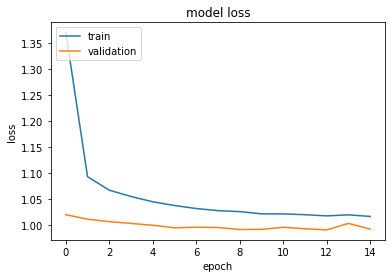

In [252]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()